# Final Project - Python Port of “nister2” Two-View Triangulation Method

**Author(s):** Azmyin Md. Kamal

**Course:** ME 7953

**Semester:** Spring 2024

**AI:** ChatGPT 4.0

## REQUIREMENTS
The following packages are requried to run this experiment
* OpenCV (>= 4.5.64)
* Numpy
* Matplotlib
* Numba
* Natsort
* PyYAML

## Abstract
The gold standard algorithm to solve the two-view triangulation problem is the ```optimal triangulation``` method (a.k.a ```hs```) proposed by Hartley and Zisserman. Globally optimal, this algorithm aims to minimioze the $L_2$ reprojection error between 2D image points matched across two images to 3D scene points based on epipolar geometry by analytically solving all the roots of a six-DOF polynomial equation. Iterative methods (a.k.a image-space) methods can also solve this non-convex optimization problem with quasi-global optimiality. However, iterative methods are successptible to initial guess, uncertainity of relative camera pose and inherent noise of observation. Lindstorm developed a novel non-iterative, image-space method called ```niter2``` that demonstrated high throughput and accruacy near to machine precision [1] . 

Based on the original C++ implementation, this project aims to develop a Python port of the ```niter2``` method. Tested in a drone and ground robot dataset, the correctness of the implementation was verified by low error in the generated point cloud and throughput speed when compared to an highly optimized C++ implementation of ```hs```. The implementaiton also demonstrated strong dependence on the type of features detected and the type of platform used to capture images.

## 1.0 Introduction
One of the fundamental use of computer vision is to recover the geometric structure of a scene from images captured by one or more calibrated/uncalibrated camera. The underlying concept to this problem is determing the location of ***scene points*** in 3D, given a set of correspoinding ***image points*** in 2D. This problem is defined as the ***Triangulation*** problem [2]. This problem is a key element of many high-level computer vision tasks such as Stereo Vision [7], Structure-from-Motion [6], robot SLAM [8], 3D Augmented reality [8a] and so on.

The gold-standard technique to this solving problem is the ***two-view triangulation*** method that states that, if the calibration matrices, pose between the cameras and noiseless feature measurement are known, then scene points are found by backprojecting a set of rays that passes through 2D image points and camera centers [2],[3],[4]. 

In reality image contains noise and thus the measured and reprojected points don't exactly conicide, i.e. does not lie on the epipolar plane [9]. Hence ***two-view triangulation*** becomes the problem of finding 3D points that best matches the observed 2D points i.e. minimize a reprojection error [2].

One of the most well known solution to ***two-view triangulation*** is Hartley and Zisserman`s ```optimal triangulation``` technique that minimizes a $L_2$ reporjection error function by finding all roots of a six DOF polynomial. 

Alternative to this ***exact*** solution schema is the ```iterative``` methods such as ***bundle adjustment*** [10] that jointly optimizes 3D scene points and camera poses and the ***image-space*** method that iterates over 2d positions based on initial estimate [11].

The primary draw back t```iterative``` methods are the dependence on good initial conditions and number of iterations required, specially when large scale scene reconstruction is required with images captured with unstable camera configurations. Furthermore, iterations cannot be stopped preemptively as early termination does not gurantee conformance to epipolar constraint [1]. 

Peter Lindstorm in 2010 paper [1], developed a new ***image-space*** globally optimal ***two-view triangulation*** technique called ```niter2```. This method optimally updates 2D pixel coordinates via intermediate steps that gurantees epipolar constraint by solving a ***quadratic*** equation instead of a ***polynomial*** equation. ```niter2``` is a ***two iteration*** method. Optimal ***epipolar lines*** are found in the first step followed by the second step that performs the back projection thereby making the technique ***non-iterative***. While not theoritically optimal, this method demonstrated faster throughput and accuracy close to machine precision in comparison to the several methods at that time when its was published. 

In this project, a Python port of ```niter2``` algorithm is presented. Its throughput and accuracy in recovering 3D scene points from pairs of calibrated images are tested in comparison to the ```optimal triangulation``` method as described in [2, 2*] and implemented in OpenCV [14]. The test scenarios involved image sequences from a drone dataset [12] and an in-house ground robot dataset [13] captured in the iCORE Lab, LSU and usage of different feature extractors and descriptors.

Results showed that the Python port was successful with 3D point clouds closely matching baseline. However, the speed improvements reported in [1,3,4] was not observed in fact, the opposite was seen.

Section 2 breifly discusses the triangulation problem and formulation presented in [1]. Section 3 that discusses the choice of datasets (changed from proposal). Section 4 presents the results and discussion obtained from this experiment and Section 5 presents conlcusion and future works.

## 2.0 Methodology
In this section, we present a preliminary discussion on the mathematical formulation of ***two-view triangulation*** followed by the formulation of the ***niter2*** algorithm.

### 2.1 Preliminaries
Let $\mathbf{I_l}$ and $\mathbf{I_r}$ be two consecutive images of a scene observed by two cameras. We assume that the cameras can be modeled using a ***linear camera*** model i.e. a ***Pinhole*** camera and they are ***calibrated***. Addtionally, images $\mathbf{I_l}, \mathbf{I_r}$ may be captured by a ***Monocular*** camera in two consecutive timesteps or by one ***Stereo*** camera in the same timestep. Regardless, the epipolar geometry is same for both cases as shown in Figure 1

![Figure 1](figs/epipolar.png)
*Figure 1: Epipolar geometry for two-view triangulation.[6a]*

Here $\mathbf{O_l}$ and $\mathbf{O_r}$ are the 3D coordinate frames of the ```left``` and ```right``` cameras respectively. A rotation $\mathbf{R} \in \mathbb{R}^{3 \times 3}$ and translation $\mathbf{t} \in \mathbb{R}^{3}$ are the relative rotation and transformation between the two cameras. $<\hat{u_l}, \hat{v_l}>$ and $<\hat{u_l}, \hat{v_l}>$ are the image coordinate frames of $\mathbf{I_l}$ and $\mathbf{I_r}$ respectively. 

Let $\mathbf{P} \in \mathbb{R}^{3}$ be a ***scene*** point and its ***porjection*** on $\mathbf{I_l}$ and $\mathbf{I_r}$ be $\mathbf{u_l} \in \mathbb{R}^{3}$ and $\mathbf{u_r} \in \mathbb{R}^{3}$ respectively. 

A projection matrix $\mathbf{M} \in \mathbb{R}^{3 \times 4}$ is a composition matrix

\begin{equation}
\mathbf{M} = \left[ \mathbf{K} \middle| 0 \right] \left[ \begin{array}{cc} \mathbf{R} & \mathbf{t} \\ \mathbf{0} & 1 \end{array} \right]
\tag{1}
\end{equation}

where $\mathbf{K}$ is the calibration matrix containing information of camera's focal length and geometric center is ```known``` in the case of a calibrated camera. $\mathbf{R}$ and $\mathbf{t}$ are ```unknown```.  

Now the problem of ```two-view triangulation```[5] is defined as

\begin{equation}
\mathbf{u_l} = \mathbf{M_l} \mathbf{P} \quad \mathbf{u_r} = \mathbf{M_r} \mathbf{P} 
\tag{2}
\end{equation}

where $\mathbf{M_l}, \mathbf{M_r}$ are the ```projection``` matrices. Solution to equation (2) is valid if it satifies the epipolar constraint 

\begin{equation}
\mathbf{u_l^T}\mathbf{E}\mathbf{u_r} = 0
\tag{3}
\end{equation}

where $\mathbf{E} \in \mathbb{R}^{3 \times 3}$ is the ***Essential*** matrix that relates $\mathbf{R}$ and $\mathbf{t}$ using the following relation

\begin{equation}
\mathbf{E} = \left[ t\right]_\times \mathbf{R}
\tag{4}
\end{equation}

This implies, if $\mathbf{E}$ can be estimated through techniques such as [6c], then Equation 3 can be computed for a calibrated stereo / two-view monocular case, and relative camera rotation and translation can be found from $\mathbf{E}$ using the ```Singular Value Decomposition``` (SVD) [6*]. Thus if $<\mathbf{u_l}, \mathbf{u_r}>$ are perfectly measured, solution to Equation 2 automatically satisfies the epipolar constraint (Equation 3) and trivially solves Equation 2

### 2.2 Non-trivial solution to Equation 2

Generally, Equation 2 has non-trivial solution since corresponding pair $<\mathbf{u_l}, \mathbf{u_r}>$ contains noise, the estimated relative pose has uncertainity and it is no possible to perfectly match up pixels with sub-pixel level accruacy [1,2,3]. 

Let us define $<\mathbf{\hat{u_l}}, \mathbf{\hat{u_v}}>$ as the set of ***corrected** points that satisfies Equation 3. Furthermore, let $\mathbf{S}$ be a matrix such that

\begin{align}
S = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 0 & 1 \end{bmatrix} \nonumber
\end{align}

Under the assumption that the image points are perturbed by Gaussian noise, Hartley and Zisserman's
***optimal triangulation*** formulates solution to Equation 3 as a least squares problem such that

\begin{align}
\text{minimize} \quad &\Delta \mathbf{u_l^T} \Delta \mathbf{u_l} + \Delta \mathbf{u_r^T}\Delta \mathbf{u_r}
\tag{6a}
\end{align}

\begin{align}
\text{subject to} \quad \mathbf{q_l}^T \mathbf{E} \mathbf{q_r}
\tag{6b}
\end{align}

where 

\begin{align}
    \mathbf{q_l} = \left( \mathbf{u_l} - \mathbf{S}^T  \right) \Delta \mathbf{u_l} \nonumber \\
    \mathbf{q_r} = \left( \mathbf{u_r} - \mathbf{S}^T  \right) \Delta \mathbf{u_r} \nonumber \\
    \Delta \mathbf{u_l} = \mathbf{S} \left( \mathbf{u_l} - \mathbf{\hat{u_l}} \right) \nonumber \\
    \Delta \mathbf{u_r} = \mathbf{S} \left( \mathbf{u_r} - \mathbf{\hat{u_r}} \right) \nonumber \\
\end{align}

As evident, Equation 6 is a ***quadratically constrained***, ***quadratic optimization*** problem [1]. 

### 2.3 ```niter2``` formulation

By introducing a Lagrange multiplier $\lambda$ into Equation 6, Lindstorm computed the epipolar constraints for the corrected pairs $<\mathbf{\hat{u_l}}, \mathbf{\hat{u_r}}>$ and develloped two ***update*** rules for the ```left```, ```right``` corresponding pairs. They are shown Equation 7

\begin{align}
    \mathbf{\hat{u_l}}^T \mathbf{E} \mathbf{\hat{u_r}} = \mathbf{q_l}^T \mathbf{E} \mathbf{q_r}
    \tag {7a}
\end{align}

\begin{align}
    \Delta \mathbf{u_l} = \lambda \mathbf{S} \mathbf{E} \mathbf{\hat{u_r}} = \lambda \mathbf{n_l}
    \tag {7b}
\end{align}

\begin{align}
    \Delta \mathbf{u_r} = \lambda \mathbf{S} \mathbf{E}^T \mathbf{\hat{u_l}} = \lambda \mathbf{n_r}
    \tag {7c}
\end{align}

Equation 7 above contains five ***unknowns*** $\left(  \Delta \mathbf{u_l}, \Delta \mathbf{u_r}, \mathbf{\lambda}  \right)$. For a $<\mathbf{\hat{u_l}}, \mathbf{\hat{u_r}}>$ pair to be a globally optimal solution to Equation 7, three conditions must be met

1. $<\mathbf{\hat{u_l}}, \mathbf{\hat{u_r}}>$ pair must lie on their respective epipolar lines
2. $<\mathbf{\hat{u_l}}, \mathbf{\hat{u_r}}>$ pair are projections of $<\mathbf{u_l}, \mathbf{u_r}>$ pair onto these projection lines
3. The correction terms $\Delta \mathbf{u_l}, \Delta \mathbf{u_r}$ are linearly related by a single parameter $\lambda$

Taking the above into consideration, Lindstorm developed two non-iterative algorithms ```niter1``` and ```niter2``` algorithms. Note that, ```niter2``` obeys only Condition 3 while ```niter1``` gurantees Conditions 1 and 2. From experimentations it was demonstrated that within two iterations, ```niter2``` converged to 12 digits or more precision. Hence, even though, theoritically not optimal (as Conditions 1 and 2 are not strictly met), ```niter2``` for all intents and purposes, is a valid algorithm and thus is the subject of study in this report.

### 2.4 ```niter2``` algorithm

Let $\mathbf{H_l} \in \mathbb{R}^{K \times 3}$ and $\mathbf{H_r} \in \mathbb{R}^{K \times 3}$ represent the set of $K$ pixel correspondences in homogeneous coordinates that are found by tracking certain non-semantic local features observed between the two images [9]. Let $\mathbf{P} \in \mathbb{R}^{K \times 4}$ be the 3D coordinates of ***scene*** points in homogeneous coordinates. Then triangulating $K$ points using the proposed method is a two step process. 

In first step ***corrected*** pixel correspondence matrices $\mathbf{\hat{H_l}} \in \mathbb{R}^{K \times 3}$ and $\mathbf{\hat{H_r}} \in \mathbb{R}^{K \times 3}$ are found by applying ```niter2```as shown in Algorithm 1. For brevity, math boldface is not used.

<img src="figs/algorithm1.png" alt="Algorithm1" width="350" height="550">

In Figure 2, Lines 3 - 12 is the first iteration step and lines 15 - 17 satisfies Condition 3. Lines 18 - 19 performs in memory update of the homogenous coordinates and Line 23 returns the updated matrices.

Once $\mathbf{\hat{H_l}}$ and $\mathbf{\hat{H_r}}$ are obtained a number of algorithms are available to solve Equation 2 such as the ```Least Squares``` method [9a] or the ```Linear``` method in [11]. As it is not part of the main contributions of ```niter2``` no further discussion on solving Equation 2 is provided in this report.

In [1]:
# Imports
import final as proj

## 3.0 Dataset and Implementation
In this section, we first present a brief discussion on the chosen datasets with explanation on why ```NotreDame``` dataset was not used as per the original proposal followed by details of the implementation

### 3.1 Datasets
The ```drone``` dataset consists of $500$ images taken from the *Machine Hall 05* image sequence available in the ```EuRoC MAV``` dataset [12]. The capture system contained a stereo imaging system but keep experiments consistent, only the left camera images were used. The size of the images are $750 \times 480$. This sequence entails surveying a large machine hall as shown in the following cell.

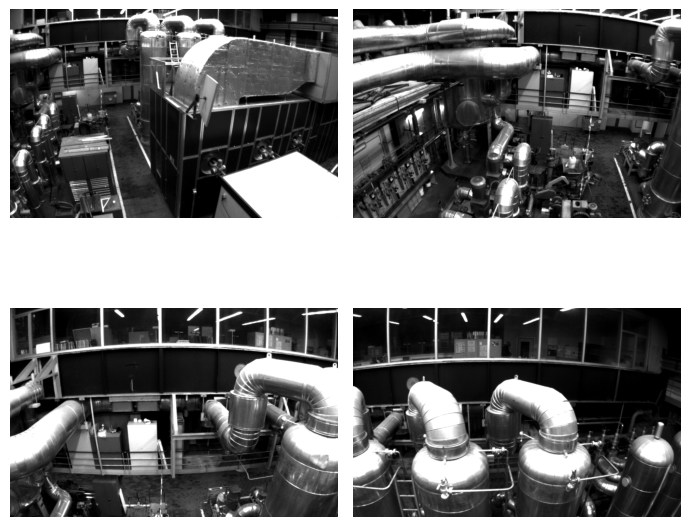

In [2]:
data_loader_1 = proj.DataSetLoader("drone")
data_loader_1.show_dataset_images()

The ```robot``` sequence is snippet of one of one of the sequencse from the ```LSU-iCORE-Mono``` dataset. This was created as part of the experiments conducted in [13]. The sequence consists of $370$ RGB images captured by a ```RBKAIROS``` industrial-grade ground robots surveying the lab space in ```iCORE``` lab. The images are $640 \times 480$. A few of them are shown below 

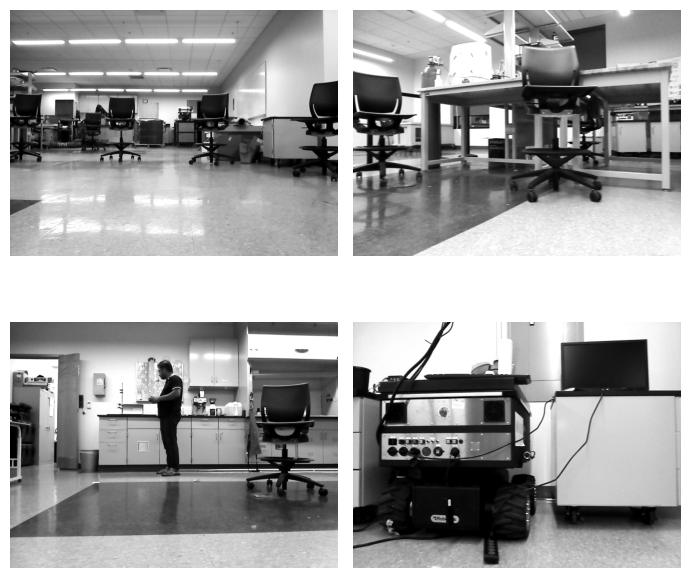

In [3]:
data_loader_2 = proj.DataSetLoader("robot")
data_loader_2.show_dataset_images()

### 3.2 Why ```NotreDame``` dataset was not used?
```NotreDame``` is a large-scale ```SfM``` dataset [15] that was aimed at building 3D models of the world from online photo collections. While $715$ RGB images were available, the dataset relied on ```Blunder``` an open-source C++ ```SfM``` system project that was created by the authors of [15]. Unfortunately this project has been abondened for nearly a decade and I was unable to find any python tools that allows extracting the camera calibration matrix $\mathbf{K}$ [Refer to Section 2.1]. Hence due to time constraints, I opted to use the datasets that from [13]  

### 3.3 Implementation
The class ```Niter2``` in ```final.py``` implements the ```niter2``` image-space iterative method discussed in Section 2.4. Similar to Lindstorm`s C++ implementation, the method ```triangulate_niter2()``` that takes in $\mathbf{H_l}$ and $\mathbf{H_r}$, applies ```niter2``` algorithm and then performs ```least-squres``` triangulation to return $\mathbf{P_c} \in \mathbb{R}^{K \times 3}$, the 3D point cloud corresponding to the detected points. Code executing ```niter2``` was written in ```Numpy``` and accelerted by Numba. We used OpenCV's highly optimized library to execute Hartley and Zisserman's ```optimal method``` (hencheforth called ```hs```) and the Nister't 5-point algorithm [6c] to estimate Essential matrix.

### 3.4 Research Questions
From [1] we observe that, the type of descriptors was not tested nor was the relative error between the two points clouds generated by various methods. Hence we formulate the following research problems:

***RQ1***: Is the throughput of the ```hs```  and ```niter2``` methods affected by the type of non-semantic features?

***RQ2***: Is the relative average RMSE between the point clouds generated by ```niter2 + least-square``` triangulation and ```hs``` triangulation shows strong variance?

***RQ3***: Are the performance of the algorithms affected by the type of image acquisition platforms (ground vs aerial)?

To test RQ1, we chose to use SIFT [16] and ORB [17] features which were matched in two camera images using the FLANN [18] algorithm. All the three methods were optimized and implemented within OpenCV. To test RQ2, we used average of RMSE score computed pariwise between the two point clouds.

Prior to beginning the experiment, it crucial to test if the feature detectors and FLANN matches have been setup correctly. The following two cells show the epilines generated for test images from ```drone``` and ```robot``` sequences for the two chosen feature detectors 

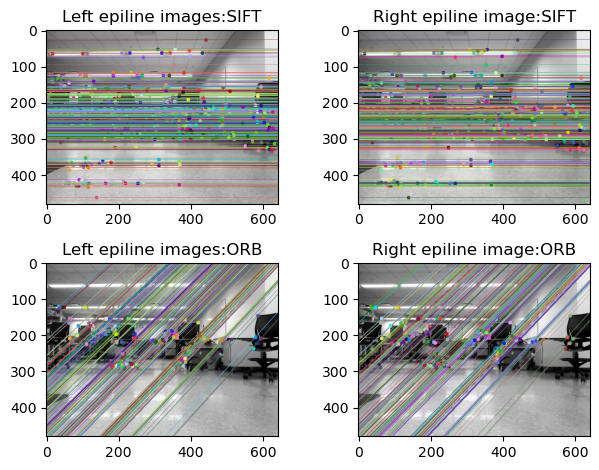

In [4]:
proj.demo_epilines("robot")

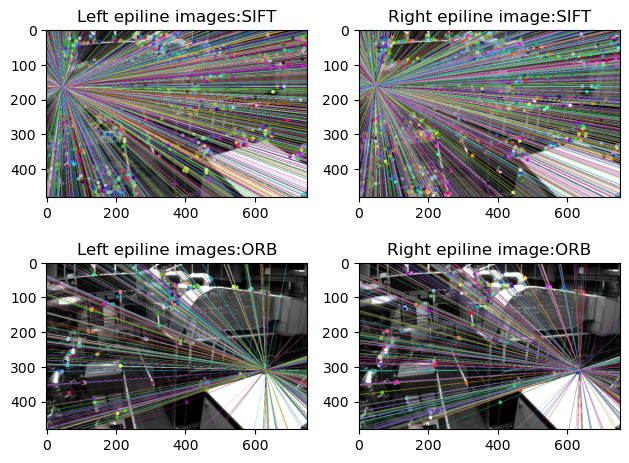

In [5]:
proj.demo_epilines("drone")

## 4.0 Results and Discussion
According [1, 3, 4], ```Points/sec``` is the measure of throughput for algorithms with higher numbers been better. Additionally, if ```niter2``` was implemented correclty, the generated point clouds should have low errors average RMSE error.  

The following cell shows the results for the ```Points/sec``` and ```average RMSE``` for the two datasets is shown below

### 4.1 ```robot``` dataset results

In [6]:
results_sift_robot = proj.perform_experiment("robot", "SIFT",
                                  full_verbose=False,
                                  short_verbose=False)
results_sift_robot.compute_rmse_get_best_points()
results_sift_robot.generate_stats()


Niter2: compiling all numba accelerated methods.
Niter2: Numba accelerated methods ready.


HS method: 1033K points/sec
Niter2 method: 46K points/sec
Average relative RMSE error: 0.3322137023330976



In [7]:
results_orb_robot = proj.perform_experiment("robot", "ORB",
                                  full_verbose=False,
                                  short_verbose=False)
results_orb_robot.compute_rmse_get_best_points()
results_orb_robot.generate_stats()


Niter2: compiling all numba accelerated methods.
Niter2: Numba accelerated methods ready.


HS method: 1054K points/sec
Niter2 method: 420K points/sec
Average relative RMSE error: 0.5189226227897192



### 4.2 ```drone``` dataset results

In [8]:
results_sift_drone = proj.perform_experiment("drone", "SIFT",
                                  full_verbose=False,
                                  short_verbose=False)
results_sift_drone.compute_rmse_get_best_points()
results_sift_drone.generate_stats()


Niter2: compiling all numba accelerated methods.
Niter2: Numba accelerated methods ready.


HS method: 1001K points/sec
Niter2 method: 265K points/sec
Average relative RMSE error: 0.2553710183356182



In [9]:
results_orb_drone = proj.perform_experiment("drone", "ORB",
                                  full_verbose=False,
                                  short_verbose=False)
results_orb_drone.compute_rmse_get_best_points()
results_orb_drone.generate_stats()


Niter2: compiling all numba accelerated methods.
Niter2: Numba accelerated methods ready.


HS method: 993K points/sec
Niter2 method: 409K points/sec
Average relative RMSE error: 0.37375038280910106



### 4.3 Points/sec
As elluded to in the Introduction section, the throughput gap between ```hs``` and ```niter2``` is significantly higher with ```hs```. Across all the four tests, ```hs``` had an average $1$ M Points/sec throughput, nearly double the speed reported by ```niter2```.

The above result may explained by the fact that ```niter2```, as presented in Algorithm 1, was not ```vectorized```, a schema that significantly improves speeds of Numpy implemented algorithms. Furthermore, in our ```niter2``` implementation, though JIT acceleration was used, the original C++ implementation had ```SSE``` and other more low-level optimizations. Finally, the ```hs``` implementation in OpenCV may have parallel processing enabled thereby making the process lot more faster than reported in [1,3,4]

However, the speed gap is very prominent for ```SIFT``` descriptors in the ```robot``` dataset with nearly $20$ times slowdown. At the time of writing this report, the author is not sure why this odd case is prevelant. This persists regardless if the entire experiment is run multiple times. Numba is known to be very slow during initial compilation. To prevent this from skewing the Points/sec results, we implemetned a ```warmup``` method that ran the JIT accelerated method multiple times until the time to execute stabilized. But this did not solve the odd casae presented above.

### 4.4 Average RMSE between point clouds
Regarding the relative error between the point clouds generated by ```hs``` and ```niter2```, we observe that both dataset had lower ```average RMSE``` value for the ```SIFT``` features. This matches observations from other computer vision application [19] where it was reported that ```SIFT``` features are more accurate and reliabile but slower to compute incomparison ```ORB``` features. We also observe that ```niter2``` method is succeptible to the type of descriptors used with spped doubled when ```ORB``` features are used. 

### 4.5 Quality of point clouds generated
The following cell presents qualitative visualizations between point clouds generated by the two methods. The first two cells shows results for the ```robot``` dataset and the latter two for the ```drone``` dataset. 

From the four [1x2] plots, we observe that, the simplified point cloud generated by the  ```niter2 + linear-triangulation``` pipeline has strong agreement with the point cloud generated by the optimized ```hs``` method. This  corroborates to the correct implementation of ```niter2``` algorithm. In seven of the eight plots, points triangulated by the ```niter2 + linear-triangulation``` pipeline appears to be spread around the 3D space for for both ```SIFT``` and ```ORB``` features. The last plot shows a paradoxical result, the RMSE value is very high yet, the point cloud appears to be well-aligned. This may be explained by the ```scale``` of the axes reported, compared to the other seven plots, the scale of this plot is much larger.

An interseting fact is evident from the eight plots, the scale of the world is inconsistent. This is expected for Monocular case [2] where the Essential matrix is estimated up to a scale [6b]. SLAM frameworks and Structure-from-Motion solves this unknown scale via stereo vision and bundle adjustment. 

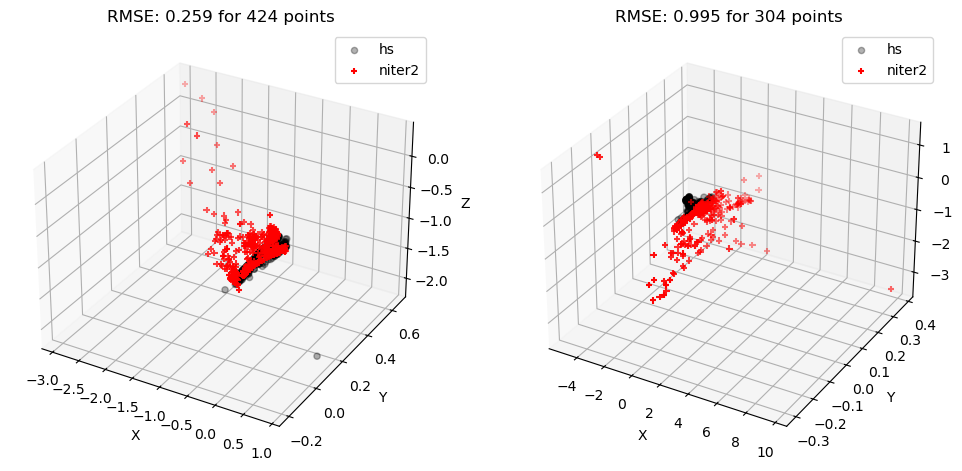

In [10]:
results_sift_robot.generate_plots()

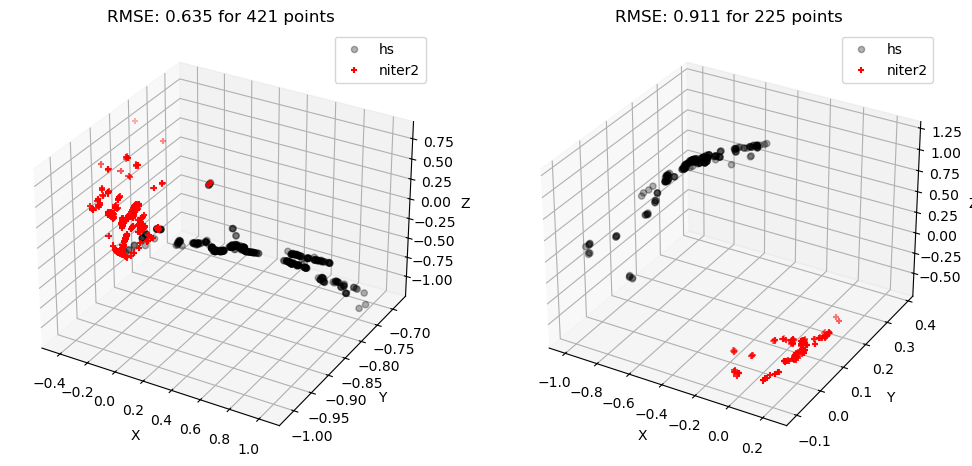

In [11]:
results_orb_robot.generate_plots()

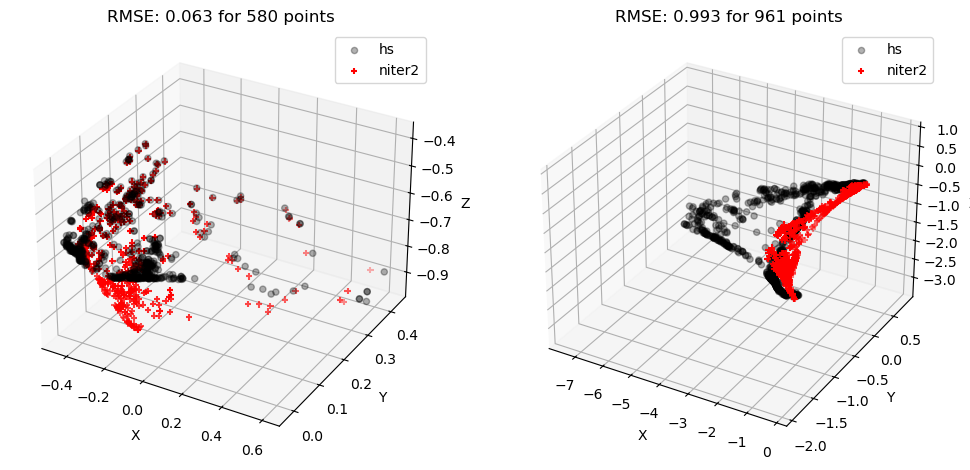

In [12]:
results_sift_drone.generate_plots()

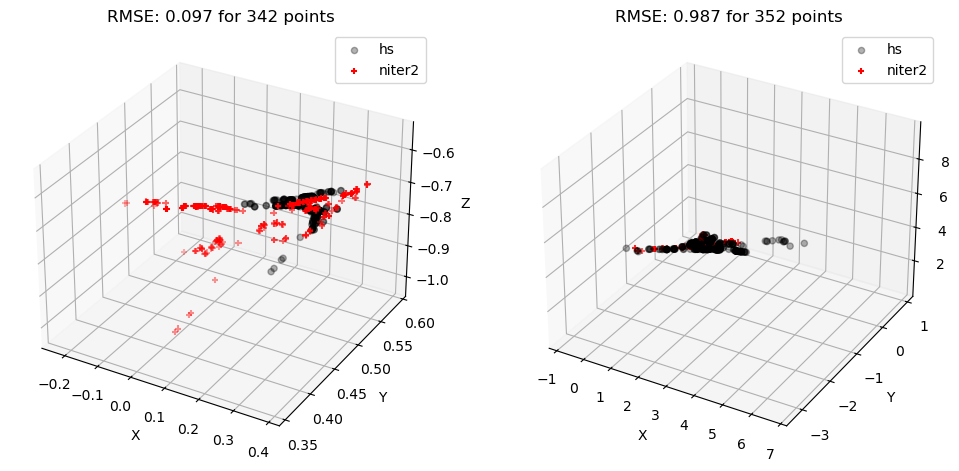

In [13]:
results_orb_drone.generate_plots()

## 5.0 Conclusion and Future Work
In this project, the fast, non-iterative, image-space, two-view triangulation method proposed by Lindstorm in [1] was implemented in Python using Numpy and Numba. Testing in comparison to OpenCV's highly optimized ```optimal triangulation``` (referred to as ```hs```) method by [2, 2*] we validated the implementation through an experimental study involving a total of $870$ images divided across a ```robot``` and a ```drone``` dataset and two popular non-semantic features, ```SIFT``` and ```ORB```. 

```niter2``` demonstrated strong dependence on the type of features used where it achieved nearly two times speedup in comparison to ```SIFT``` features in both datasets. However, due to the non-vectorized nature and lack of low-level optimization of Algorithm 1, ```niter2``` was less than half as fast as ```hs```, thereby not demostrating the speed advantage as demonstrated in [1,3,4].

The relative RMSE error between the points cloud generated by the two methods demonstrated good qualitative and quantitative agreements thereby corroborating to the correctness of the implementation. Additionally, the point clouds generated from  ```SIFT``` features had overall lower error matching the observation from the computer vision literature. 

Finally ```hs``` method showed no variance in performance for the type of data capture platform (drone vs ground)  whilst ```niter2``` showed variance in performance with ```SIFT``` features for ground robots.

Some limitation of this project includes the occasionally invalid points generated by the ```linear-triangulation``` function, the lack of Numba acceleration of the ```linear-triangulation``` or lack of use of a ```least-squares``` method that might have reduced RMSE variance further. In future we hope to utilize PyTorch and CUDA to convert Algorithm 1 into a parallely processed method for speeding up computation and/or attempt to convert Algorithm 1 into a fully vectorized method.

## References

[1] Peter Lindstorm, (2010), "Triangulation Made Easy"

[2] Hartley and Zisserman, "Multiview Geometry, Chapter 12: Triangulation"

[2*] Beardsley, Zisserman and Murray, (1994) "Navigation using affine structure from motion"

[3] Lee and Civera, (2019), "Closed Form Optimal Two-View Triangulation Based on Angular Errors"

[4] Lee and Civera, "Triangulation: Why optimize?"

[5] Amy Tabb, "N-view triangulation: DLT method", URL: https://amytabb.com/tips/tutorials/2021/10/31/triangulation-DLT-2-3/

[6] Shree Nayar, "Structure From Motion Problem" URL: https://www.youtube.com/watch?v=JlOzyyhk1v0

[6a] Shree Nayar, "Epipolar Geometry: Uncalibrated Stereo", URL: https://www.youtube.com/watch?v=6kpBqfgSPRc

[6b] Shree Nayaer, "Estimating Fundamental Matrix", URL: https://www.youtube.com/watch?v=izpYAwJ0Hlw&t=259s

[6c] D Nister, (2004), "An Efficient Solution to the Five--point Relative Pose Problem", URL: http://16720.courses.cs.cmu.edu/lec/two-view2.pdf

[7] Tippetts et al. (2016), "Review of stereo vision algorithms and their suitability for resource-limited systems"

[8] C Campos et al. (2020), "ORB-SLAM3"

[8a] Li, Snavely, Huttenlocher, "Location Recognition using Prioritized Feature Matching" URL: https://www.cs.cornell.edu/projects/p2f/

[9] Stachniss, (2020), "Triangualtion from Image Pairs", URL: https://www.youtube.com/watch?v=UZlRhEUWSas&t=143s\

[9a] R. Sara, (2012), "The Triangulation Problem", URL: http://cmp.felk.cvut.cz/cmp/courses/TDV/2012W/lectures/
tdv-2012-07-anot.pdf

[10] Triggs et al. (1992), "Bundle Adjustment - a modern synthesis"

[11] Kanatani and Niitsuma, (1995), "Reliability of 3D reconstruction by stereo vision" 

[12] Burri et al. (2016), "The EuRoC micro aerial vehicle datasets"

[13] Kamal and Barbalata, (2024), "Solving Short-Term Relocalization Problems In Monocular Keyframe
Visual SLAM Using Spatial And Semantic Data", Accepted in IEEE AIM 2024

[14] OpenCV, "Triangulation" URL: https://docs.opencv.org/4.x/d0/dbd/group__triangulation.html

[15] BigSFM: Reconstructing the World from Internet Photos, URL: https://www.cs.cornell.edu/projects/bigsfm/

[16] D Lowe, (2004) "Scale-Invariant Feature Transform", URL: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

[17] Konolige and Bardski, (2011) "ORB: An efficient alternative to SIFT or SURF"

[18] Arandjelovic, (2012), "Three things everyone should know to improve object retrieval"

[19] Karami and Shehata, "Image Matching Using SIFT, SURF, BRIEF and ORB: Performance Comparison for Distorted Images"